In [1]:
%pylab inline
import pandas as pd
import sys
import gc

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.insert(0,"../python/rrvf2017/")

In [3]:
from rrvf_data import read_data,show_data,show_data2,show_features, normalize, DataGen

In [4]:
columns,data=read_data()
len(columns),data.shape

(1, 829, 517) (36, 829, 517)


(44, (829, 517, 44))

In [5]:
gc.collect()

15

In [6]:
#show_data(data,columns, 1,480, None)

In [7]:
#show_data2(data,columns)

# cv

In [8]:
n_reg_lookback=42
n_lookforward=1

In [9]:
def get_index(cols):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [10]:
rawy=data[:,:,get_index(['visitors'])[0]].copy()
rawy.shape

(829, 517)

In [11]:
ondate_cols=[ u'visitor_lag91', u'visitor_lag182',
       u'visitor_lag364',u'TMAX', u'TMIN', u'TAVG', u'PRCP', u'holiday',
            'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2',
       'weekday1', 'weekday0']
#ondate_cols=[ u'PRCP']
#ondate_cols=columns
ondate_train_test=data[:,:,get_index(ondate_cols)].copy()
ondate_train_test=normalize(ondate_train_test)
ondate_train_test.shape

(15,) 0.0676982591876 123.878437859


(829, 517, 15)

In [12]:
lag_cols=columns

lag_cols=array([u'visitors', u'geo1_visitors_mean', u'geo2_visitors_mean',
       u'station_visitors_mean', u'genre_name_visitors_mean',
       u'day_of_week_visitors_mean', u'visitor_lag7', u'visitor_lag14',
       u'visitor_lag28', u'visitor_lag91', u'visitor_lag182',
       u'visitor_lag364', u'visitor_ma2', u'visitor_ma4', u'visitor_ma7',
       u'visitor_ma14', u'visitor_ma28', u'visitor_ma56', u'visitor_ma112',
       u'visitor_ma224', u'visitor_sma1', u'visitor_sma2', u'visitor_sma3',
       u'visitor_sma4', u'visitor_sma8', u'visitor_sma16',
       u'visitor_sma32'])
#lag_cols=['holiday']
lag_train_test=data[:,:,get_index(lag_cols)].copy()
lag_train_test=normalize(lag_train_test)
lag_train_test.shape

(27,) 2.78591754939 3.02795093092


(829, 517, 27)

In [13]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [14]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


In [15]:
print K.floatx()

float32


In [16]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [17]:
train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1,478-n_lookforward*7, batchsize=128,valid_split=0.1,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
valid_gen=None
test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-n_lookforward*7,478, batchsize=128,lookback1=n_reg_lookback, lookforward=n_lookforward)

rand split across time
train has 319288 records out of 354812 records
valid has 35524 records out of 354812 records
train has 5803 records out of 5803 records
no valid set


In [18]:
print train_gen.train_steps_per_epoch
print 0 if valid_gen is None else valid_gen.train_steps_per_epoch

2494
0


In [19]:
#show_features(train_gen,ondate_cols,lag_cols,rawy,0,467,filter_fn=lambda u: 'y_0' in u)

In [20]:
lag_input_dim=lag_train_test.shape[-1]
ondate_input_dim=ondate_train_test.shape[-1]
lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)

(27, 15, (1, 15))

In [21]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['gompertz_error'],
            "patience":[3],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'gompertz_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 3})

In [22]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [23]:
backend.clear_session()
set_session(tf.Session(config=config))   
a=rrvf.KerasModel("test", n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                  ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim,
                  max_epoch=200, use_output_exp=True,
                  params=parameter)
a._make_model()
a.params

(?, 42, 54)


{'activation': 'relu',
 'batch_normalization': False,
 'l2': 1e-06,
 'loss': 'gompertz_error',
 'metric': 'mean_squared_error',
 'optimizer': 'adam',
 'patience': 3}

In [24]:
#a.model.summary()
gc.collect()
a.model.count_params()

459011

In [25]:
np.nanmin(rawy)

0.69314718246459961

In [26]:
a.fit(train_gen,valid_gen)

Epoch 1/200
2494/2494 [==============================] - 50s 20ms/step - loss: nan - total_loss: nan - reg_loss: 2.3151 - val_loss: 1.2319 - val_total_loss: 1.2319 - val_reg_loss: 0.3023
Epoch 2/200
2494/2494 [==============================] - 49s 20ms/step - loss: 1.2314 - total_loss: 1.2314 - reg_loss: 0.3329 - val_loss: 1.2091 - val_total_loss: 1.2091 - val_reg_loss: 0.3050
Epoch 3/200
2494/2494 [==============================] - 48s 19ms/step - loss: 1.2249 - total_loss: 1.2249 - reg_loss: 0.3284 - val_loss: 1.2029 - val_total_loss: 1.2029 - val_reg_loss: 0.3029
Epoch 4/200
2494/2494 [==============================] - 48s 19ms/step - loss: 1.2178 - total_loss: 1.2178 - reg_loss: 0.3203 - val_loss: 1.1953 - val_total_loss: 1.1953 - val_reg_loss: 0.3036
best_epochs [4, 3, 2, 1]
individual loss [ 0.3028686   0.30245245  0.30556988  0.30217272]
[  4.94854086e-01   0.00000000e+00  -1.17476242e-17   5.05145914e-01] 0.285615021779


<rrvf_model.KerasModel instance at 0x7f22783e9c20>

In [106]:
K.get_session().run(a.nb.mu)

array([ 0.12], dtype=float32)

In [78]:
a.traingen=train_gen

In [79]:
a.eval_valid()

best_epochs [5, 4, 2, 6, 3]
0.298333992951 0.298333992951
(1, 0.29833399295135976)


In [80]:
yy_pred=a.predict(300)
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

best_epochs [1, 2, 3, 4, 5]
(829, 1) 2.54931660185 (829,)
0.289941666951 0.289941666951
(1, 0.28994166695144646)


In [81]:
traindata=train_gen.get_train()

In [82]:
def predict_train(self):
    X, y, mask,w = self.traingen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X

In [83]:
def predict_test(self):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X

In [58]:
gc.collect()

375

In [99]:
result=predict_train(a)

best_epochs [1, 2, 3, 4, 5]
(319288, 1) 2.65061856689 (319288, 2)


In [100]:
result[4].keys()

['masky', 'ondatex', 'lagx']

In [101]:
result[4]['lagx'].shape

(319288, 42, 27)

In [102]:
df=pd.DataFrame({'y':result[2][:,0]})

In [103]:
df['pred']=result[0][:,0]
df['dayidx']=result[1][:,1]

In [104]:
df=df.loc[df['y']>0]

In [105]:
df['error']=df['y']-df['pred']
df['error2']=df['error']**2


In [106]:
import rrvf_data

In [107]:
df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)

In [108]:
plt.hist(df.y,bins=30);

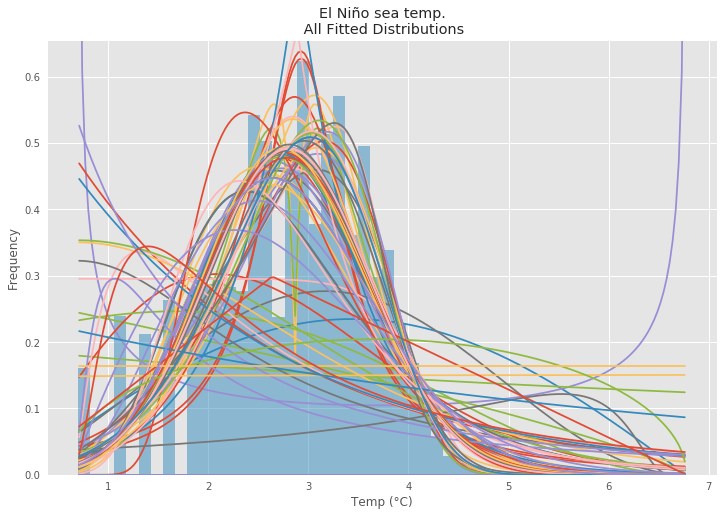

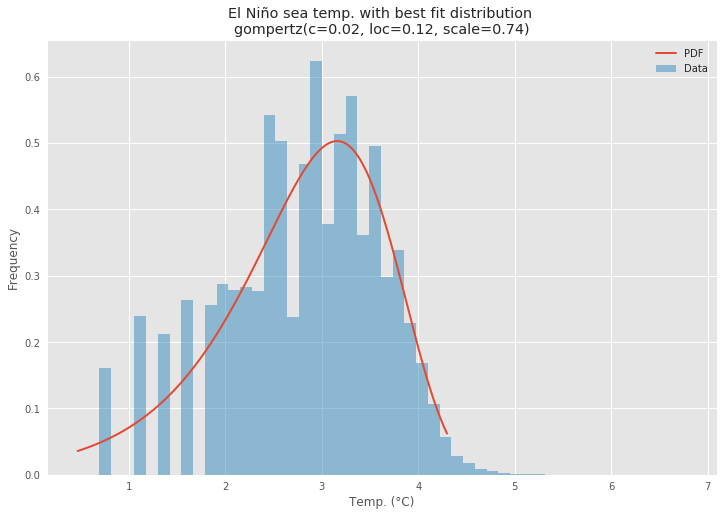

In [141]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Propbability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = df['y']

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5, color=plt.rcParams['axes.color_cycle'][1])
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF
pdf = make_pdf(best_dist, best_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fir_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')

In [150]:
log(exp(-3.9) + 1)

0.020039767260397558

In [154]:
stats.gompertz.stats(0.02, moments='mvsk')

(array(3.422477375827614),
 array(1.2697041050297475),
 array(-0.5809996354603606),
 array(-0.027136774698243826))

In [155]:
log(-1/0.02*log(0.5)+1)

3.57395554990548

In [157]:
-log(0.5)/(exp(3.57395554990548)-1)

0.020000000000000004

(0.97126234952016155, 0.22287534790961017, 0.9982494204496557)

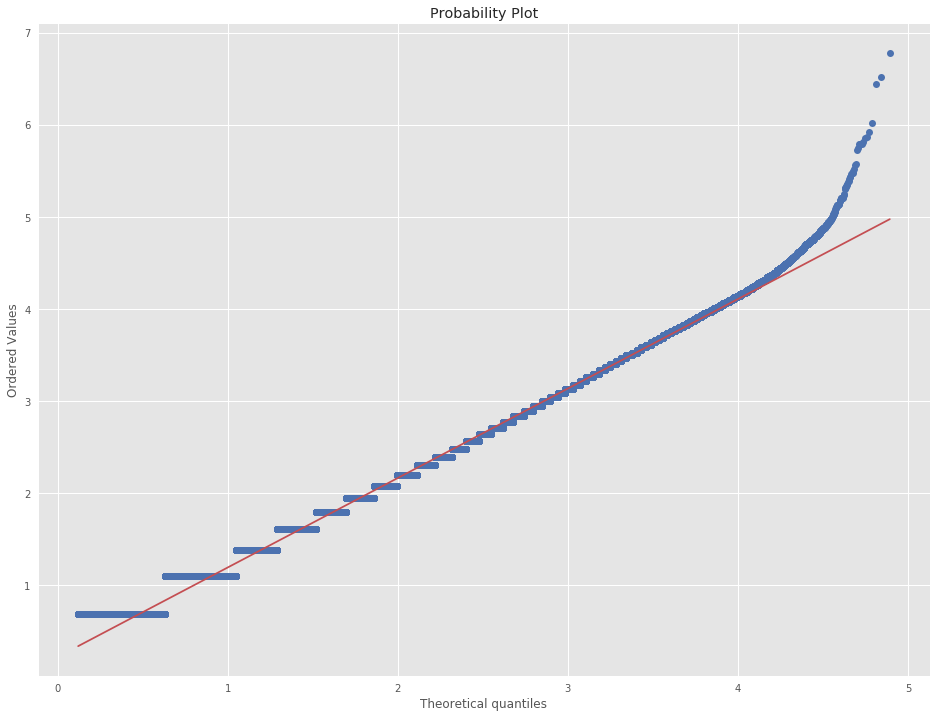

In [142]:
import scipy.stats as stats
_,b=stats.probplot(df.y.values, dist=stats.gompertz,sparams=(0.02,0.12,0.74), plot=pylab);
b

(0.80314679347917972, 2.7992782592773438, 0.98993767612169548)

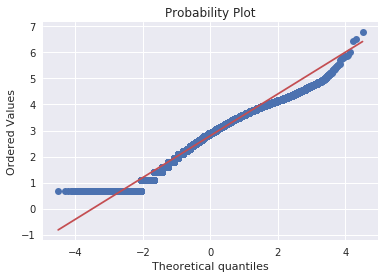

In [127]:
import scipy.stats as stats
_,b=stats.probplot(df.y.values, dist=stats.norm, plot=pylab);
b

In [126]:
import scipy.stats as stats
_,b=stats.probplot(df.y.values, dist=stats.loggamma,sparams=(2.5,), plot=pylab);
b

(1.1503751274089733, 1.9903801414204469, 0.99288874776790392)

In [70]:
import seaborn as sns; sns.set(color_codes=True)

In [71]:
if 0:
    for i in range(1,8):
        plt.plot(np.arange(1,5),np.arange(1,5)*0)
        sns.kdeplot(df['y'][df['day']==i].values,df['error'][df['day']==i].values, shade=True)
        plt.show()

1


2


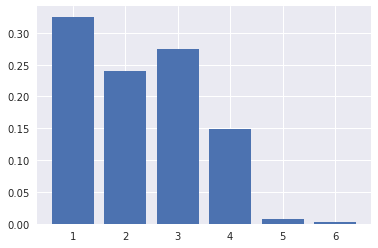

3


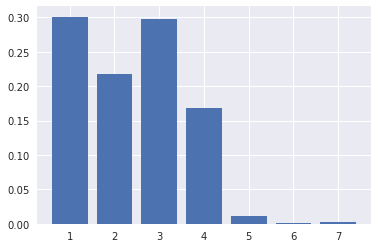

4


5


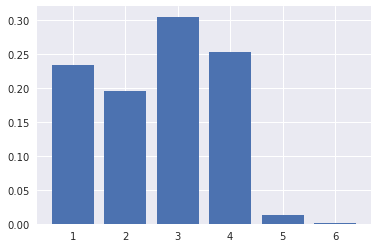

6


7


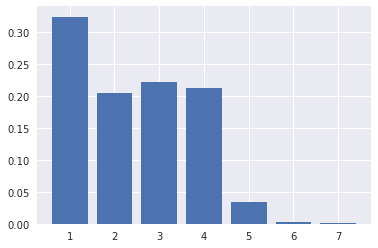

In [72]:
df['tmp']=np.round(df['y'])
for i in range(1,8):
    print i
    s=df[['tmp','error2']][df['day']==i].groupby('tmp').sum().iloc[:,0]
    plt.bar(s.index,s.values/s.sum())
    plt.show()

In [73]:
np.expm1(2)

6.3890560989306504

In [74]:
gc.collect()

35858

In [75]:
df2=df.groupby("dayidx").mean() 

In [76]:
df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())

In [77]:
df2[['day','error2']].groupby('day').median()

error2
day          
1    0.301697
2    0.268015
3    0.258422
4    0.270001
5    0.225165
6    0.222182
7    0.305818

In [78]:
rrvf_data.idx_to_date([477])

array(['2017-04-22'],
      dtype='|S10')

In [79]:
df2.tail(20)

y      pred     error    error2  day       tmp        date
dayidx                                                                   
451     2.663319  2.613595  0.049724  0.293593    1  2.655000  2017-03-27
452     2.771063  2.706323  0.064741  0.284807    2  2.748485  2017-03-28
453     2.892115  2.819792  0.072323  0.221427    3  2.906298  2017-03-29
454     2.844926  2.805574  0.039352  0.246607    4  2.837719  2017-03-30
455     2.963802  2.863310  0.100493  0.229060    5  2.934844  2017-03-31
456     3.003109  3.022810 -0.019701  0.230699    6  3.005797  2017-04-01
457     2.887328  2.872761  0.014566  0.294615    7  2.861111  2017-04-02
458     2.633656  2.653629 -0.019974  0.306366    1  2.632027  2017-04-03
459     2.654599  2.684546 -0.029947  0.285233    2  2.651633  2017-04-04
460     2.735434  2.723393  0.012041  0.253489    3  2.726006  2017-04-05
461     2.657448  2.658729 -0.001281  0.272273    4  2.653789  2017-04-06
462     2.892388  2.807306  0.085082  0.232274    5  2.873039  2017-04-07
463     3.032275  3.005805  0.026470  0.212124    6  3.033237  2017-04-08
464     2.845081  2.877995 -0.032915  0.313301    7  2.834265  2017-04-09
465     2.550302  2.528724  0.021578  0.280511    1  2.551959  2017-04-10
466     2.499668  2.569432 -0.069764  0.296560    2  2.500000  2017-04-11
467     2.710481  2.619959  0.090522  0.259135    3  2.697017  2017-04-12
468     2.721618  2.605685  0.115933  0.242166    4  2.723122  2017-04-13
469     2.955262  2.839251  0.116011  0.233045    5  2.945225  2017-04-14
470     3.130256  3.106153  0.024103  0.171279    6  3.130058  2017-04-15

1


2


3


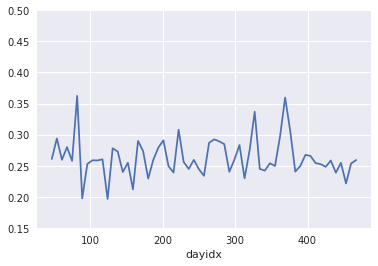

4


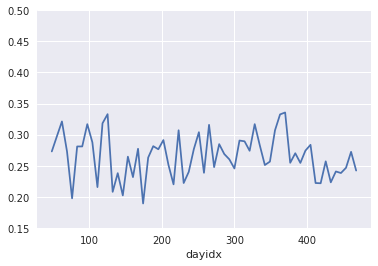

5


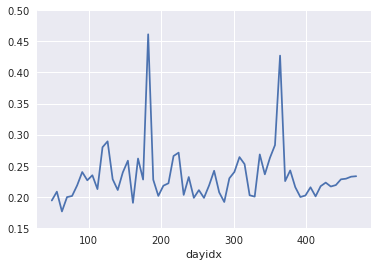

6


7


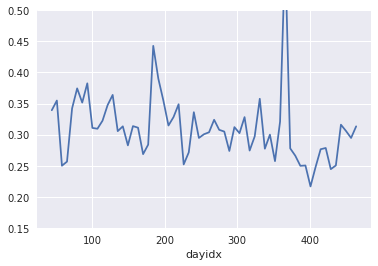

In [80]:
for i in range(1,8):
    print i
    df2[df2['day']==i]['error2'].plot();
    plt.ylim([0.15,0.5])
    plt.show()

In [81]:
df2.sort_values('error2').tail(20)

y      pred     error    error2  day       tmp        date
dayidx                                                                   
331     2.799895  2.850078 -0.050183  0.357703    7  2.785714  2016-11-27
369     2.721701  2.796412 -0.074711  0.359587    3  2.742382  2017-01-04
445     2.600821  2.697141 -0.096319  0.359650    2  2.599668  2017-03-21
82      2.782760  2.842761 -0.060001  0.362365    3  2.782787  2016-03-23
128     2.909813  2.991500 -0.081687  0.363912    7  2.870647  2016-05-08
185     2.596966  2.614493 -0.017528  0.370379    1  2.583480  2016-07-04
79      3.082346  2.974681  0.107665  0.374426    7  3.098592  2016-03-20
122     2.929583  2.716189  0.213395  0.380664    1  2.931193  2016-05-02
129     2.480333  2.658704 -0.178371  0.382022    1  2.487437  2016-05-09
93      2.899247  2.991998 -0.092750  0.382541    7  2.898396  2016-04-03
191     2.897560  2.829507  0.068053  0.390144    7  2.894837  2016-07-10
263     2.372732  2.584277 -0.211545  0.392182    2  2.379249  2016-09-20
183     3.056708  3.022765  0.033943  0.394437    6  3.043939  2016-07-02
115     2.648150  2.690023 -0.041874  0.412325    1  2.638498  2016-04-25
364     3.036463  2.989142  0.047321  0.427118    5  3.044487  2016-12-30
234     2.350633  2.503891 -0.153257  0.432674    1  2.362264  2016-08-22
184     2.880746  2.843388  0.037358  0.442891    7  2.864604  2016-07-03
182     3.006450  2.795948  0.210502  0.461411    5  3.022059  2016-07-01
365     2.720622  2.860874 -0.140252  0.544248    6  2.708185  2016-12-31
366     2.705143  2.731503 -0.026360  0.593151    7  2.703704  2017-01-01

In [82]:
holiday=pd.read_csv('../input/date_info.csv')
holiday=holiday[holiday['holiday_flg']==1]

In [84]:
import rrvf_data

In [85]:
result=predict_test(a)

best_epochs [1, 2, 3, 4, 5]
(5803, 1) 2.63656017102 (5803, 2)


In [86]:
df=pd.DataFrame({'y':result[2][:,0]})

In [87]:
df['pred']=result[0][:,0]
df['dayidx']=result[1][:,1]

In [88]:
df=df.loc[df['y']>0]

In [89]:
df['error']=df['y']-df['pred']
df['error2']=df['error']**2


In [90]:
df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)

In [91]:
df2=df.groupby("dayidx").mean() 

In [92]:
df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())

In [93]:
df2

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.808463  0.120647  0.314586    7  2017-04-16
472     2.507290  2.484526  0.022765  0.273568    1  2017-04-17
473     2.661330  2.531589  0.129741  0.316499    2  2017-04-18
474     2.754815  2.580258  0.174556  0.284995    3  2017-04-19
475     2.713762  2.576155  0.137606  0.298862    4  2017-04-20
476     2.999000  2.785441  0.213559  0.228020    5  2017-04-21
477     3.075529  2.923110  0.152419  0.237179    6  2017-04-22

# time split

In [32]:
train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1,478-n_lookforward*4, 
                  batchsize=128,valid_split=0.0,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward,valid_type=None)
valid_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-n_lookforward*4,478-n_lookforward*2, 
                  batchsize=128,valid_split=0.0,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward,valid_type=None)
test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-n_lookforward,478, batchsize=128,lookback1=n_reg_lookback, lookforward=n_lookforward)

train has 357299 records out of 357299 records
no valid set
train has 1658 records out of 1658 records
no valid set
train has 829 records out of 829 records
no valid set


In [33]:
print train_gen.train_steps_per_epoch
print 0 if valid_gen is None else valid_gen.train_steps_per_epoch

2791
12


In [34]:
#show_features(train_gen,ondate_cols,lag_cols,rawy,0,467,filter_fn=lambda u: 'y_0' in u)

In [35]:
lag_input_dim=lag_train_test.shape[-1]
ondate_input_dim=ondate_train_test.shape[-1]
lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)

(27, 8, (1, 8))

In [36]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "patience":[3],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'mean_squared_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 3})

In [37]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [38]:
backend.clear_session()
set_session(tf.Session(config=config))   
a=rrvf.KerasModel("test", n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                  ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim,
                  max_epoch=200,
                  params=parameter)
a._make_model()
a.params

(?, 42, 54)


{'activation': 'relu',
 'batch_normalization': False,
 'l2': 1e-06,
 'loss': 'mean_squared_error',
 'metric': 'mean_squared_error',
 'optimizer': 'adam',
 'patience': 3}

In [39]:
#a.model.summary()
print gc.collect()
a.model.count_params()

454


455425

In [40]:
a.fit(train_gen,valid_gen)

Epoch 1/200
2791/2791 [==============================] - 57s 20ms/step - loss: 0.3199 - total_loss: 0.3199 - reg_loss: 2.5995 - val_loss: 0.2717 - val_total_loss: 0.2717 - val_reg_loss: 0.9499
Epoch 2/200
2791/2791 [==============================] - 56s 20ms/step - loss: 0.2837 - total_loss: 0.2837 - reg_loss: 2.5131 - val_loss: 0.2499 - val_total_loss: 0.2499 - val_reg_loss: 0.8878
Epoch 3/200
2791/2791 [==============================] - 56s 20ms/step - loss: 0.2746 - total_loss: 0.2746 - reg_loss: 2.4670 - val_loss: 0.2563 - val_total_loss: 0.2563 - val_reg_loss: 0.8219
Epoch 4/200
2791/2791 [==============================] - 57s 20ms/step - loss: 0.2676 - total_loss: 0.2676 - reg_loss: 2.4382 - val_loss: 0.2747 - val_total_loss: 0.2747 - val_reg_loss: 0.8155
Epoch 5/200
2791/2791 [==============================] - 56s 20ms/step - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 2.3925 - val_loss: 0.2606 - val_total_loss: 0.2606 - val_reg_loss: 0.8171


<rrvf_model.KerasModel instance at 0x7f7e885d5d88>

In [41]:
#a.traingen=train_gen

In [42]:
a.eval_valid()

best_epochs [2, 3, 5, 1, 4]
0.258842468217 0.258842468217
(1, 0.25884246821678769)


In [43]:
yy_pred=a.predict(400)

best_epochs [1, 2, 3, 4, 5]
(829, 1) 3.02983174963 (829,)


In [44]:
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

0.190820011306 0.190820011306
(1, 0.19082001130563031)


In [49]:
n_lookforward

1

In [50]:
yy_pred=a.predict(478-n_lookforward-1)
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

best_epochs [1, 2, 3, 4, 5]
(829, 1) 2.87643025494 (829,)
0.182698888629 0.182698888629
(1, 0.18269888862869477)


In [51]:
yy_pred=a.predict(478-n_lookforward-2)
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

best_epochs [1, 2, 3, 4, 5]
(829, 1) 2.62079328142 (829,)
0.270138534272 0.270138534272
(1, 0.27013853427158546)


In [52]:
yy_pred=a.predict(478-n_lookforward-3)
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

best_epochs [1, 2, 3, 4, 5]
(829, 1) 2.60231247107 (829,)
0.243763329538 0.243763329538
(1, 0.24376332953775123)


In [53]:
yy_pred=a.predict(478-n_lookforward-4)
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

best_epochs [1, 2, 3, 4, 5]
(829, 1) 2.52984273246 (829,)
0.278246599289 0.278246599289
(1, 0.27824659928872975)


In [45]:
yy_pred=a.predict(478-n_lookforward)

best_epochs [1, 2, 3, 4, 5]
(829, 1) 3.06015446194 (829,)


In [46]:
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

0.209365883356 0.209365883356
(1, 0.20936588335586601)
